In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
#import xgboost as xgb

from IPython.display import display
from pandas import DataFrame, Series

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

C:\Users\rvlfl_000\Anaconda3\lib\site-packages\matplotlib\__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [11]:
rossmann_df  = pd.read_csv("input/train.csv")
store_df     = pd.read_csv("input/store.csv")
test_df      = pd.read_csv("input/test.csv")

# Map string features to integers
# This map function is very convienient
rossmann_df["StateHoliday"] = rossmann_df["StateHoliday"].map({0: 0, "0": 0, "a": 1, "b": 2, "c": 3})
test_df["StateHoliday"]     = test_df["StateHoliday"].map({0: 0, "0": 0, "a": 1, "b": 2, "c": 3})

# Create Year and Month columns
rossmann_df['Year']  = rossmann_df['Date'].apply(lambda x: int(str(x)[:4]))
rossmann_df['Month'] = rossmann_df['Date'].apply(lambda x: int(str(x)[5:7]))

test_df['Year']  = test_df['Date'].apply(lambda x: int(str(x)[:4]))
test_df['Month'] = test_df['Date'].apply(lambda x: int(str(x)[5:7]))

# Assign Date column to Date(Year-Month) instead of (Year-Month-Day)
# this column will be useful in analysis and visualization
rossmann_df.rename(columns={"Date":"Time"}, inplace=True)
test_df.rename(columns={"Date":"Time"}, inplace=True)
rossmann_df['Date'] = rossmann_df['Time'].apply(lambda x: (str(x)[:7]))
test_df['Date']     = test_df['Time'].apply(lambda x: (str(x)[:7]))

rossmann_df["Sales"] = np.log(rossmann_df["Sales"])

# Notice that test_df has only year=2015, and months 8 & 9

# rossmann_df = rossmann_df.loc[rossmann_df["Month"].isin([7,8,9])]

# drop Year and Month
# rossmann_df.drop(["Year", "Month"], axis=1, inplace=True)
# test_df.drop(["Year", "Month"], axis=1, inplace=True)


# Create dummy varibales for DayOfWeek
# Why not directly use the value? I think the point is that DayOfWeek is a categorical value.
# The number itself has no meaning. That's why dummy is better than the value.
day_dummies_rossmann  = pd.get_dummies(rossmann_df['DayOfWeek'], prefix='Day')
day_dummies_rossmann.drop(['Day_7'], axis=1, inplace=True)

day_dummies_test  = pd.get_dummies(test_df['DayOfWeek'],prefix='Day')
day_dummies_test.drop(['Day_7'], axis=1, inplace=True)

rossmann_df = rossmann_df.join(day_dummies_rossmann)
test_df     = test_df.join(day_dummies_test)

rossmann_df.drop(['DayOfWeek'], axis=1,inplace=True)
test_df.drop(['DayOfWeek'], axis=1,inplace=True)

# remove all rows(store,date) that were closed
rossmann_df = rossmann_df[rossmann_df["Open"] != 0]

# drop unnecessary columns, these columns won't be useful in prediction
rossmann_df.drop(["Open","Customers", "Date"], axis=1, inplace=True)


# save ids of closed stores, because we will assign their sales value to 0 later(see below)
closed_store_ids = test_df["Id"][test_df["Open"] == 0].values

# remove all rows(store,date) that were closed
test_df = test_df[test_df["Open"] != 0]

# drop unnecessary columns, these columns won't be useful in prediction
test_df.drop(['Open', 'Date'], axis=1,inplace=True)

C:\Users\rvlfl_000\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2902: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


### Preparing Data for ML

In [12]:

# Since the data are time series, we do not start with the cross-validation.
# Rather, we use the most recent 6 week data as the validation set, and the rest as the training set.
# TODO: I think there will be better methods to handle time series data?

train_df = rossmann_df.loc[~rossmann_df['Time'].isin(
        pd.date_range('2015-06-20', periods=6 * 7).astype(str))]


# We want the algorithm to consider month. One method is to use only months for the validation set.
# But this also significantly reduces the sample size.
train_df = train_df.loc[rossmann_df["Month"].isin([6, 7])]

validation_df = rossmann_df.loc[rossmann_df['Time'].isin(
        pd.date_range('2015-06-20', periods=6 * 7).astype(str))]

display(train_df.head())
display(validation_df.head())
print(train_df.shape)
print(validation_df.shape)

train_dict = dict(list(train_df.groupby('Store')))
validation_dict = dict(list(validation_df.groupby('Store')))

test_dic = dict(list(test_df.groupby('Store')))

,Store,Time,Sales,Promo,StateHoliday,SchoolHoliday,Year,Month,Day_1,Day_2,Day_3,Day_4,Day_5,Day_6
46830,1,2015-06-19,8.343316,1,0,0,2015,6,0,0,0,0,1,0
46831,2,2015-06-19,8.502283,1,0,0,2015,6,0,0,0,0,1,0
46832,3,2015-06-19,8.996404,1,0,0,2015,6,0,0,0,0,1,0
46833,4,2015-06-19,9.178437,1,0,0,2015,6,0,0,0,0,1,0
46834,5,2015-06-19,8.650149,1,0,0,2015,6,0,0,0,0,1,0


,Store,Time,Sales,Promo,StateHoliday,SchoolHoliday,Year,Month,Day_1,Day_2,Day_3,Day_4,Day_5,Day_6
0,1,2015-07-31,8.568456,1,0,1,2015,7,0,0,0,0,1,0
1,2,2015-07-31,8.710125,1,0,1,2015,7,0,0,0,0,1,0
2,3,2015-07-31,9.025696,1,0,1,2015,7,0,0,0,0,1,0
3,4,2015-07-31,9.546455,1,0,1,2015,7,0,0,0,0,1,0
4,5,2015-07-31,8.480944,1,0,1,2015,7,0,0,0,0,1,0


(127881, 14)
(40282, 14)


### Prediction - Evaluation

In [14]:
# Evaluation

# Use cross-validation to evaluate different methods. Basically, for each machine learning configuration,
# we want to have a score.

# A machine learning config = method + data


def rmspe(yhat, y):
    # Learn how to efficiently do ndarray calculation, see the original in 
    # https://www.kaggle.com/paso84/rossmann-store-sales/xgboost-in-python-with-rmspe/code
    return np.sqrt(np.mean(((y - yhat) / y)**2))

methods = ["Random Forest"]

# Other methods: ["Logistic Regression", "Linear Regression"]
# Logistic Regression is really slow and inaccurate.
# Linear Regression is slightly worse than Random Forest


# for method in methods:
    
def predict(method):
    print("Working on " + method)
    
    Y = np.empty([0])
    Y_hat = np.empty([0])
    store_ids = []
    times = []

    for i in test_dic:

        X_train = train_dict[i].drop(["Sales", "Store", "Time", "Year", "Month"],axis=1)
        Y_train = train_dict[i]["Sales"]

        X_validation  = validation_dict[i].copy()
        X_validation.drop(["Sales", "Store", "Time", "Year", "Month"], axis=1,inplace=True)
        Y_validation = validation_dict[i]["Sales"]
        _times = validation_dict[i]["Time"]
        

        if method == "Random Forest":
            rf = RandomForestRegressor()
            rf.fit(X_train, Y_train)
            Y_pred = rf.predict(X_validation)
            
        elif method == "Linear Regression":
            lreg = LinearRegression()
            lreg.fit(X_train, Y_train)
            Y_pred = lreg.predict(X_validation)
            
        elif method == "Logistic Regression":
            lgr = LogisticRegression()
            lgr.fit(X_train, Y_train)
            Y_pred = lgr.predict(X_validation)

        Y = np.append(Y, np.exp(Y_validation))
        Y_hat = np.append(Y_hat, np.exp(Y_pred))
        store_ids += [i] * len(Y_pred)
        
        times += list(_times)
            
    print(np.shape(Y_hat))
    print(rmspe(Y_hat, Y))

    diff = pd.Series(Y_hat - Y)
    diff_df = pd.DataFrame({"Diff":diff, "Store":store_ids, "Time":times})
    
    return diff_df

_diff_df = predict("Random Forest")

   

Working on Random Forest
(30960,)
0.182954382109


### Error Analysis

TODO: Now, we want to see the error of each instance. We hope to answer the following questions:
1. Is there a systematic bias in prediction?
2. What about the variance?
3. How can we improve?


For RMSPE, is it sensitive to outliers? If so, we can spend more time to correct the outliers.

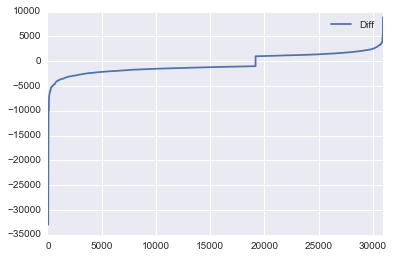

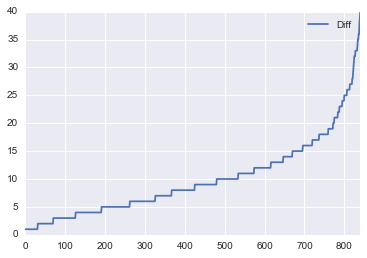

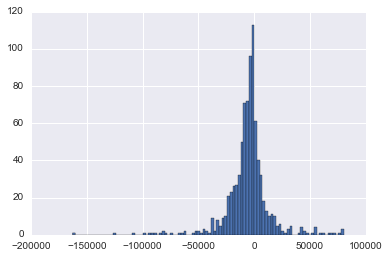

count       841.000000
mean      -5539.317300
std       20146.438489
min     -162906.864657
25%      -11331.933183
50%       -4313.562515
75%         847.994924
max       80203.712488
Name: Diff, dtype: float64


,Diff,Store,Time
17,1523.472352,1,2015-07-11
29,1034.472352,1,2015-06-27
38,1083.316194,3,2015-07-29
40,1927.405330,3,2015-07-27
46,1960.130039,3,2015-07-20
58,1022.130039,3,2015-07-06
63,-3889.533207,3,2015-06-30
69,-1255.453470,3,2015-06-23
93,-1399.391877,7,2015-07-07
94,-2825.297972,7,2015-07-06


In [138]:

diff_df = _diff_df.loc[abs(_diff_df["Diff"]) > 1000]

# Show error distribution

diff_df.sort_values(by = ["Diff"]).plot(x = diff_df.index, y = "Diff")

# One effect of this line is to generate a unique figure
plt.show()

# Show large predictions
# display(diff_df.loc[abs(diff_df["Diff"]) > 1000])

# TODO: We can see that most predictions are pretty good. But there are some extremely large errors.
# Can we find out them?


# We want to see the count of large errors for each store
# From the result, we can see that most stores have 36 large errors!
# I feel there is a strong bias.
diff_df.groupby("Store").count().sort_values(by = ["Diff"]).plot(x = np.arange(0, len(diff_df.groupby("Store"))), y = "Diff")

# This makes sure that the figure is shown in this position.
plt.show()


# We now get the sum of errors for each store. We want to see if there is a systematic prediction bias.
# From the results, seems that there is a slight shifts to the left.
store_sum = diff_df.groupby("Store")['Diff'].sum()
store_sum.hist(bins = 100)

# This makes sure that the figure is shown in this position.
plt.show()

print(store_sum.describe())


# We look at the errors of some stores
# We can see that store 7 is always negative (underestimated)
# In the exploration note, it seems that store 7 will have 
display(diff_df.sort_values(by = ["Store"]).loc[diff_df["Store"].isin([1,2,3,4,5,6,7])])

In [167]:
# Loop through each store, 
# train the model using the data of current store, and predict it's sales values.

rossmann_dic = dict(list(rossmann_df.groupby('Store')))
test_dic     = dict(list(test_df.groupby('Store')))
submission   = Series()
scores       = []


for i in test_dic:
    
    # current store
    store = rossmann_dic[i]
    
    # define training and testing sets
    X_train = store.drop(["Sales","Store", "Time"],axis=1)
    Y_train = store["Sales"]
    X_test  = test_dic[i].copy()
    
    store_ids = X_test["Id"]
    X_test.drop(["Id","Store", "Time"], axis=1,inplace=True)
    
    if method == "Linear Regression":
        lreg = LinearRegression()
        lreg.fit(X_train, Y_train)
        Y_pred = lreg.predict(X_test)
        scores.append(lreg.score(X_train, Y_train))
    elif method == "Xgboost":
        params = {"objective": "reg:linear",  "max_depth": 10}
        T_train_xgb = xgb.DMatrix(X_train, Y_train)
        X_test_xgb  = xgb.DMatrix(X_test)
        gbm = xgb.train(params, T_train_xgb, 100)
        Y_pred = gbm.predict(X_test_xgb)
    elif method == "Random Forest":
        rf = RandomForestRegressor()
        rf.fit(X_train, Y_train)
        Y_pred = rf.predict(X_test)
        scores.append(rf.score(X_train, Y_train))
    
    # append predicted values of current store to submission
    submission = submission.append(Series(Y_pred, index=store_ids))

# append rows(store,date) that were closed, and assign their sales value to 0
submission = submission.append(Series(0, index=closed_store_ids))

# save to csv file
submission = pd.DataFrame({ "Id": submission.index, "Sales": submission.values})
submission.to_csv('rossmann.csv', index=False)